





# Recommender Systems with LightFM






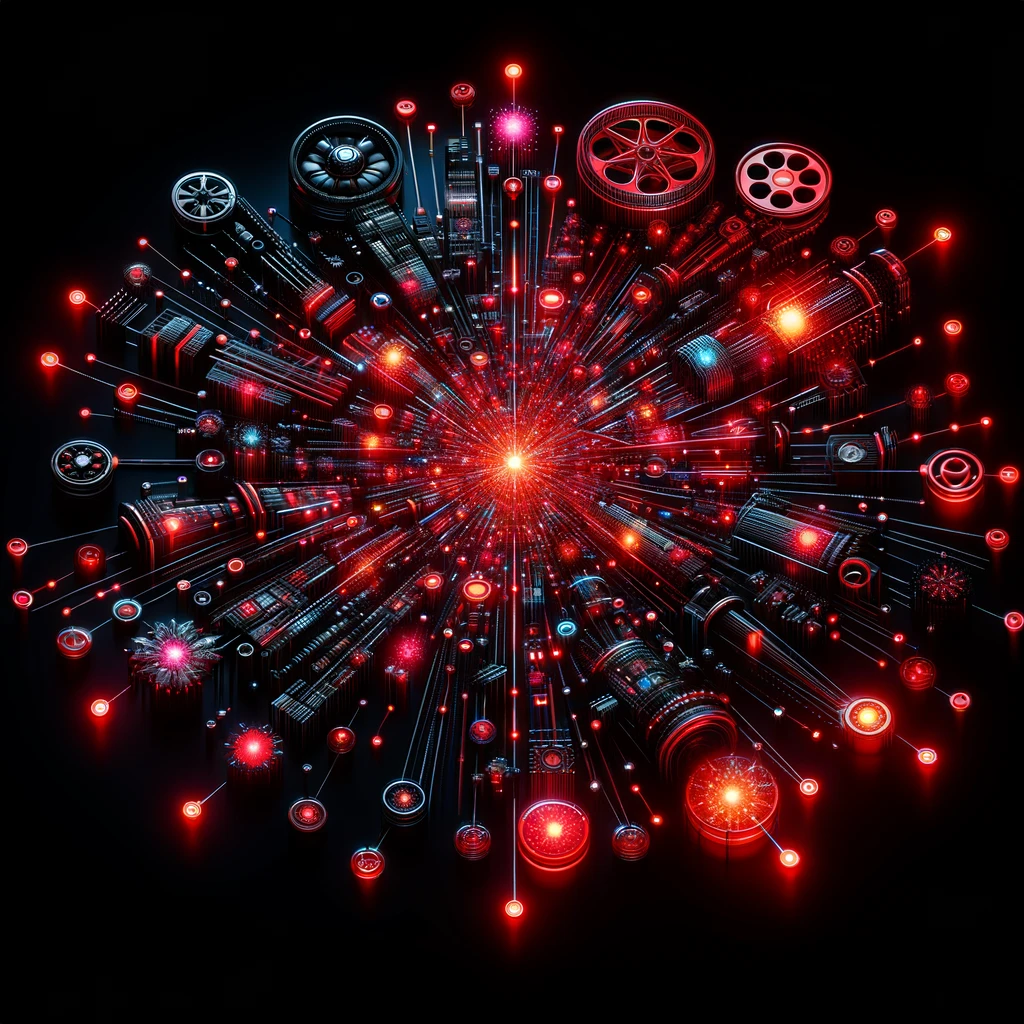




## Introduction
This project focuses on building and evaluating a movie recommendation system using a dataset of user-movie interactions.

## Project Steps

### Step 1: Data Loading and Preprocessing
- Read `movies.txt` and create a DataFrame `movies_df`.
- Read `movie_users_10_20.txt` and create a DataFrame `movie_users_df`.
- Convert relevant columns to appropriate data types.

### Step 2: Data Merging
- Merge `movie_users_df` and `movies_df` on `movie_id`.

### Step 3: Creating User-Item Interaction Matrix
- Pivot the merged DataFrame to create an interaction matrix with users as rows, movies as columns, and ratings as values.

### Step 4: Creating Sparse Matrix
- Map user and movie IDs to unique indices.
- Create a COO (Coordinate Format) sparse matrix from the interaction data.
- Optionally convert the COO matrix to CSR (Compressed Sparse Row) format.

### Step 5: Model Training and Evaluation
- Initialize and train the LightFM model with WARP loss.
- Evaluate the model using precision and recall at k.

### Step 6: Generating Recommendations
- Define a function `get_top_recommendations` to predict top N movie recommendations for a given user.
- Generate and display recommendations for selected users.




In [32]:
import pandas as pd

# Reading movies.txt
movies_data = []
with open('movies.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('###')
        if len(parts) == 3:
            movie_id, year, title = parts
            #movies_data.append({'movie_id': movie_id, 'year': year, 'title': title})
            movies_data.append({'movie_id': movie_id, 'title': title})


movies_df = pd.DataFrame(movies_data)

In [33]:
movies_df.head()

,movie_id,title
0,1,Dinosaur Planet
1,2,Isle of Man TT 2004 Review
2,3,Character
3,4,Paula Abdul's Get Up & Dance
4,5,The Rise and Fall of ECW


In [34]:
import pandas as pd

movie_users_data = []
current_movie_id = None

with open('movie_users_10_20.txt', 'r') as file:
    for line in file:
        line = line.strip()
        if line.endswith(':'):
            # Update current movie ID
            current_movie_id = line.replace(':', '').strip()
        else:
            # Process user interaction
            parts = line.split(',')
            if len(parts) == 3:
                user_id, rating, timestamp = parts
                movie_users_data.append({
                    'user_id': user_id, 
                    'movie_id': current_movie_id, 
                    'rating': rating, 
                })

movie_users_df = pd.DataFrame(movie_users_data)

# Convert data types as needed
movie_users_df['user_id'] = pd.to_numeric(movie_users_df['user_id'], errors='coerce')
movie_users_df['movie_id'] = pd.to_numeric(movie_users_df['movie_id'], errors='coerce')
movie_users_df['rating'] = pd.to_numeric(movie_users_df['rating'], errors='coerce')
#movie_users_df['timestamp'] = pd.to_datetime(movie_users_df['timestamp'], errors='coerce')

# Display the first few rows
movie_users_df.head()


,user_id,movie_id,rating
0,2165002,1,4
1,1989766,1,4
2,2530404,1,3
3,2625019,1,3
4,1357013,1,3


In [35]:
print(movie_users_df.items)

<bound method DataFrame.items of         user_id  movie_id  rating
0       2165002         1       4
1       1989766         1       4
2       2530404         1       3
3       2625019         1       3
4       1357013         1       3
...         ...       ...     ...
590959  1557684     11499       5
590960  1273697     14305       1
590961   194091      8833       4
590962  1784944     16477       5
590963  2131419     16553       2

[590964 rows x 3 columns]>


In [36]:
print(movies_df.items)

<bound method DataFrame.items of       movie_id                                              title
0            1                                    Dinosaur Planet
1            2                         Isle of Man TT 2004 Review
2            3                                          Character
3            4                       Paula Abdul's Get Up & Dance
4            5                           The Rise and Fall of ECW
...        ...                                                ...
17765    17766  Where the Wild Things Are and Other Maurice Se...
17766    17767                  Fidel Castro: American Experience
17767    17768                                              Epoch
17768    17769                                        The Company
17769    17770                                       Alien Hunter

[17770 rows x 2 columns]>


In [37]:
movie_users_df.describe

<bound method NDFrame.describe of         user_id  movie_id  rating
0       2165002         1       4
1       1989766         1       4
2       2530404         1       3
3       2625019         1       3
4       1357013         1       3
...         ...       ...     ...
590959  1557684     11499       5
590960  1273697     14305       1
590961   194091      8833       4
590962  1784944     16477       5
590963  2131419     16553       2

[590964 rows x 3 columns]>

### Step 1: Merge DataFrames 

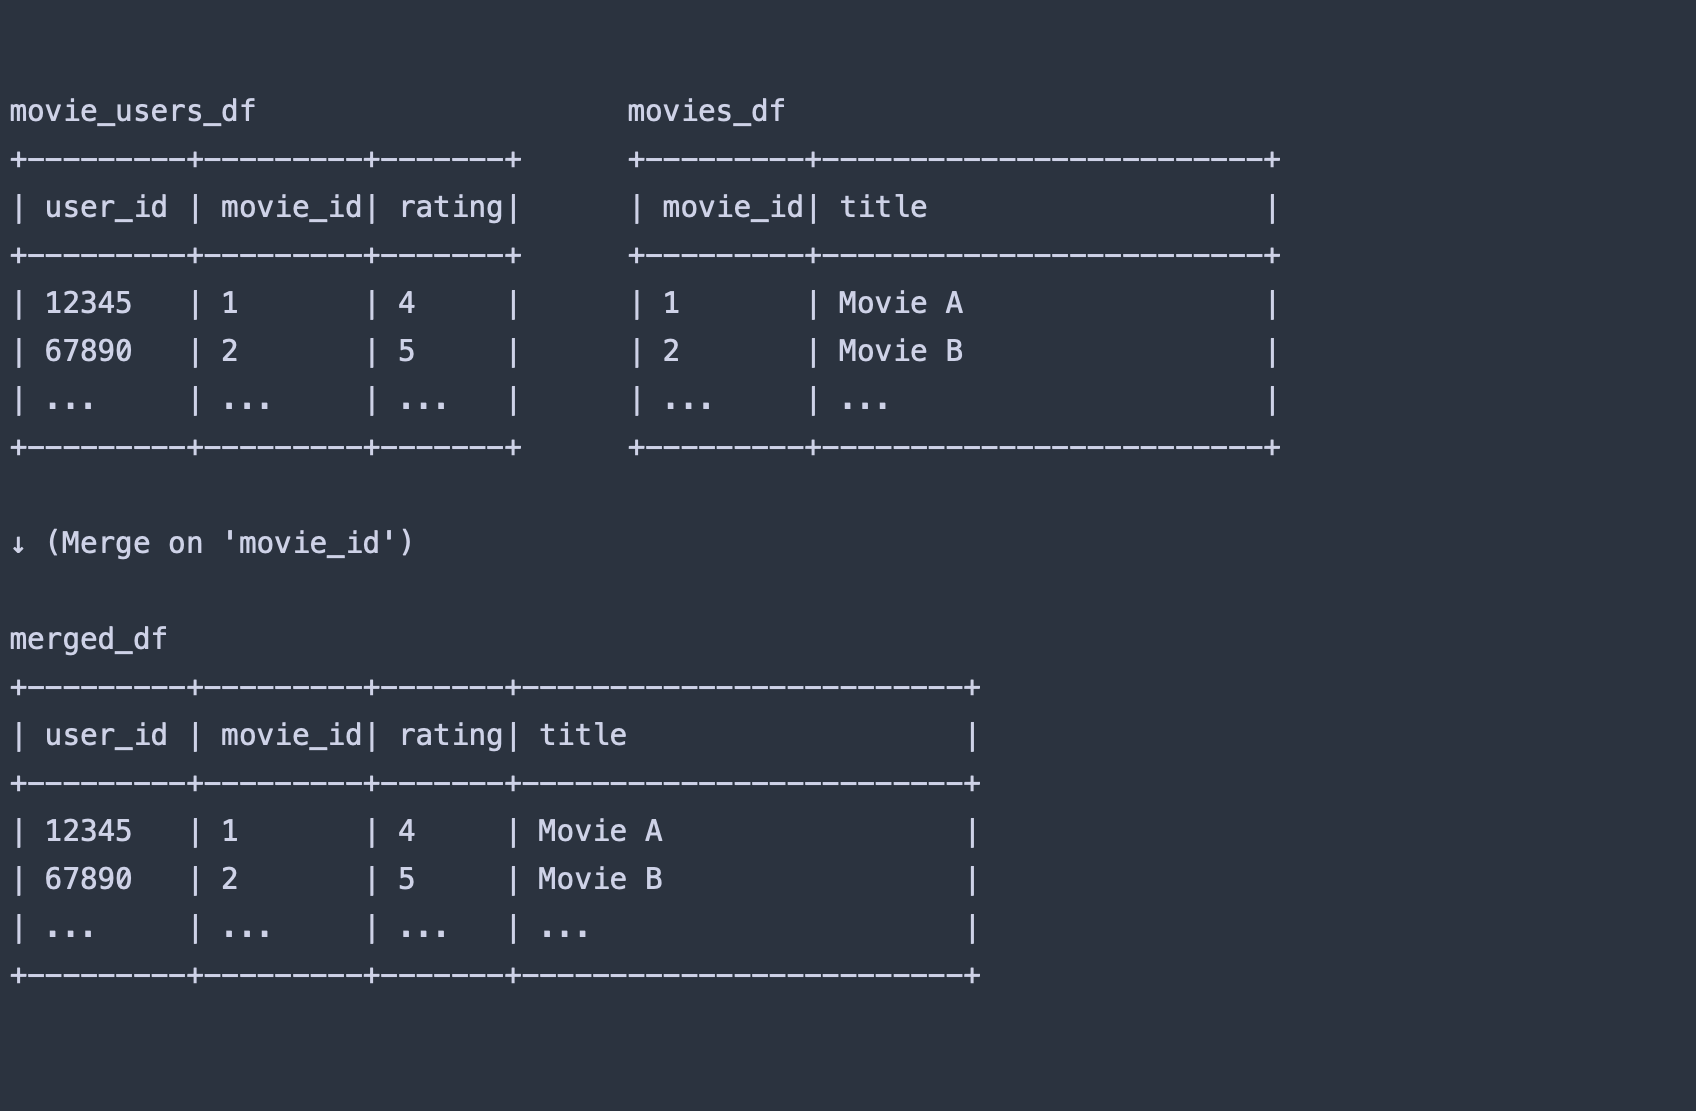



In [38]:
import pandas as pd

# Assuming movie_users_df and movies_df are already loaded

# Step 1: Ensure Consistent Data Types
movie_users_df['movie_id'] = movie_users_df['movie_id'].astype(int)  # or str
movies_df['movie_id'] = movies_df['movie_id'].astype(int)

# Step 2: Merge DataFrames
merged_df = pd.merge(movie_users_df, movies_df, on='movie_id')

print(merged_df)



        user_id  movie_id  rating  \
0       2165002         1       4   
1       1989766         1       4   
2       2530404         1       3   
3       2625019         1       3   
4       1357013         1       3   
...         ...       ...     ...   
590959  1557684     11499       5   
590960  1273697     14305       1   
590961   194091      8833       4   
590962  1784944     16477       5   
590963  2131419     16553       2   

                                                    title  
0                                         Dinosaur Planet  
1                                         Dinosaur Planet  
2                                         Dinosaur Planet  
3                                         Dinosaur Planet  
4                                         Dinosaur Planet  
...                                                   ...  
590959                                          Peter Pan  
590960                                      Wild Orchid 2  
590961  Foolish

### Step 2: Create a User-Item Interaction Matrix

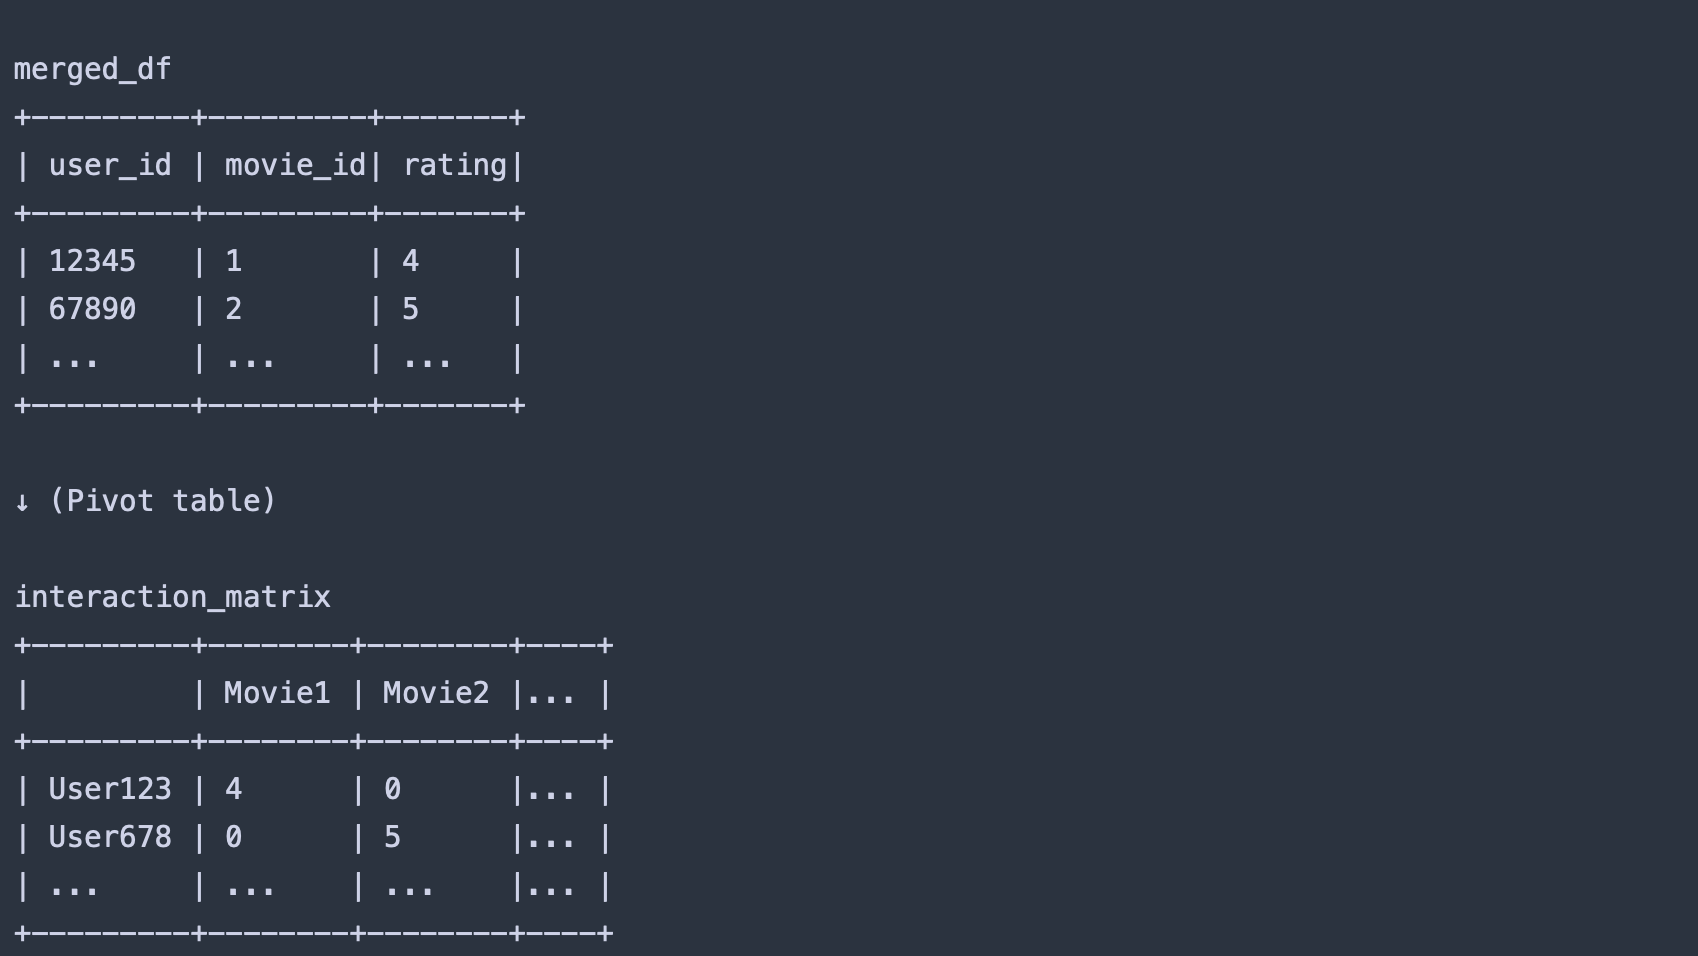


In [39]:
# Step 3: Create a User-Item Interaction Matrix
interaction_matrix = merged_df.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)

# Display the first few rows of the merged data and interaction matrix
print(merged_df.head())

   user_id  movie_id  rating            title
0  2165002         1       4  Dinosaur Planet
1  1989766         1       4  Dinosaur Planet
2  2530404         1       3  Dinosaur Planet
3  2625019         1       3  Dinosaur Planet
4  1357013         1       3  Dinosaur Planet


In [40]:
from scipy.sparse import coo_matrix
import numpy as np

# Create a mapping for user and movie IDs to indices
user_ids = merged_df['user_id'].unique()
movie_ids = merged_df['movie_id'].unique()
user_id_to_index = {user_id: i for i, user_id in enumerate(user_ids)}
movie_id_to_index = {movie_id: i for i, movie_id in enumerate(movie_ids)}

# Map the user and movie IDs to the corresponding indices
merged_df['user_index'] = merged_df['user_id'].map(user_id_to_index)
merged_df['movie_index'] = merged_df['movie_id'].map(movie_id_to_index)

# Create the sparse matrix
sparse_matrix = coo_matrix(
    (merged_df['rating'], (merged_df['user_index'], merged_df['movie_index'])),
    shape=(len(user_ids), len(movie_ids))
)

# Optional: Convert to CSR format for more efficient arithmetic operations
sparse_matrix_csr = sparse_matrix.tocsr()

# Display the sparse matrix
print(sparse_matrix)
#(1,0) 4 indicates that the user at index 1 also rated the movie at index 0 with a score of 4.


  (0, 0)	4
  (1, 0)	4
  (2, 0)	3
  (3, 0)	3
  (4, 0)	3
  (5, 0)	3
  (6, 0)	5
  (7, 0)	5
  (0, 1)	3
  (8, 1)	4
  (9, 1)	4
  (10, 1)	3
  (11, 1)	4
  (12, 1)	5
  (13, 1)	4
  (14, 1)	5
  (15, 1)	4
  (16, 1)	3
  (17, 1)	4
  (18, 1)	4
  (19, 1)	4
  (20, 1)	4
  (21, 1)	3
  (22, 1)	3
  (23, 1)	4
  :	:
  (13074, 15220)	2
  (37221, 15221)	1
  (32497, 15222)	4
  (24107, 15223)	3
  (24109, 15224)	3
  (33060, 15225)	3
  (36883, 15226)	5
  (24639, 15227)	5
  (33191, 15228)	2
  (37802, 15229)	3
  (32562, 15230)	3
  (28379, 15231)	5
  (16034, 15232)	4
  (35295, 15233)	1
  (36985, 15234)	3
  (19020, 15235)	1
  (19020, 15236)	1
  (32875, 15237)	2
  (3342, 15238)	3
  (35234, 15239)	3
  (16202, 15240)	5
  (9450, 15241)	1
  (32522, 15242)	4
  (27813, 15243)	5
  (37410, 15244)	2


### WARP (Weighted Approximate-Rank Pairwise) Loss:
#### Loss Function:
The model uses the WARP loss function. WARP focuses on optimizing the ranking of the recommendations. It prioritizes getting the top few recommendations right, which is often more useful in recommendation systems than just predicting ratings accurately.
#### How WARP Works: 
WARP samples negative items (items the user hasn't interacted with) and updates the model weights in a way that the rank of the positive items (items the user has interacted with) is improved. This involves repeatedly sampling until it finds a negative item that the model currently ranks above the positive item, then updating the model to correct this.

In [41]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank

# Initialize the LightFM Model
model = LightFM(loss='warp')  # Using WARP (Weighted Approximate-Rank Pairwise) loss



In [42]:
# Train the Model, designed to be scalable
model.fit(sparse_matrix_csr, epochs=30, num_threads=5)

#### LightFM offers Rich Evaluation Metrics

In [45]:
# Evaluate the Model
precision = precision_at_k(model, sparse_matrix_csr, k=5).mean()
recall = recall_at_k(model, sparse_matrix_csr, k=5).mean()
auc = auc_score(model, sparse_matrix_csr).mean()
mrr = reciprocal_rank(model, sparse_matrix_csr).mean()

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')
print(f'MRR: {mrr}')


Precision: 0.22971020638942719
Recall: 0.0738403587323026
AUC: 0.9756965637207031
MRR: 0.41394683718681335


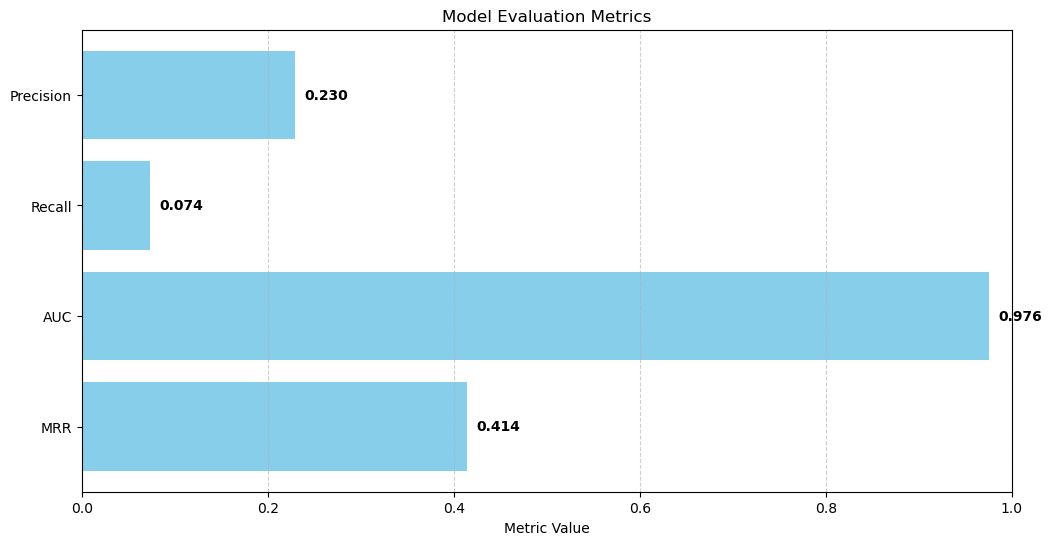

In [49]:
import matplotlib.pyplot as plt

# Define the evaluation metrics and their values
metrics = ['Precision', 'Recall', 'AUC', 'MRR']
values = [precision, recall, auc, mrr]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(metrics, values, color='skyblue')
plt.xlabel('Metric Value')
plt.title('Model Evaluation Metrics')
plt.xlim(0, 1)  # Adjust the x-axis limit if needed

# Display the metric values on the bars
for i, v in enumerate(values):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center', color='black', fontweight='bold')

plt.gca().invert_yaxis()  # Invert the y-axis to have the highest metric at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()


In [46]:
# Iterate through the first 10 user IDs and print them
for user_id in list(user_id_to_index.keys())[:10]:
    print(user_id)


2165002
1989766
2530404
2625019
1357013
2054180
470861
2380848
1533635
691162


In [47]:
# First, define n_items based on the shape of your sparse matrix
n_items = sparse_matrix_csr.shape[1]

# Create a reverse mapping from indices to movie IDs
index_to_movie_id = {index: movie_id for movie_id, index in movie_id_to_index.items()}

def get_top_recommendations(user_id, model, n_items, top_n=10):
    user_index = user_id_to_index[user_id]
    scores = model.predict(user_index, np.arange(n_items))
    top_indices = np.argsort(-scores)[:top_n]
    top_movie_ids = [index_to_movie_id[index] for index in top_indices]
    top_movie_titles = movies_df[movies_df['movie_id'].isin(top_movie_ids)]['title'].tolist()
    return top_movie_titles

# Predict for three users
user_ids = [2054180, 2165002, 1989766]  # Example user IDs

for user_id in user_ids:
    top_movies = get_top_recommendations(user_id, model, n_items)
    print(f"Top recommended movies for user {user_id}: {top_movies} \n\n")


Top recommended movies for user 2054180: ['Shrek 2', 'Finding Nemo (Widescreen)', 'Monsters, Inc.', 'Harry Potter and the Chamber of Secrets', 'Lord of the Rings: The Two Towers', 'Harry Potter and the Prisoner of Azkaban', 'Ella Enchanted', 'Shrek (Full-screen)', 'The Day After Tomorrow', "Harry Potter and the Sorcerer's Stone"] 


Top recommended movies for user 2165002: ['Brother Bear (Theatrical Widescreen Version)', 'Freaky Friday', 'Finding Nemo (Widescreen)', 'Cheaper by the Dozen', 'Daddy Day Care', 'Monsters, Inc.', 'Lord of the Rings: The Two Towers', 'Ella Enchanted', '13 Going on 30', 'The Lion King 1 1/2'] 


Top recommended movies for user 1989766: ['50 First Dates', 'Super Size Me', 'Shrek 2', 'Finding Nemo (Widescreen)', 'Shark Tale', 'Collateral', 'The Incredibles', 'Meet the Fockers', 'Spider-Man 2', 'Harry Potter and the Prisoner of Azkaban'] 




## LightFM hybrid approach


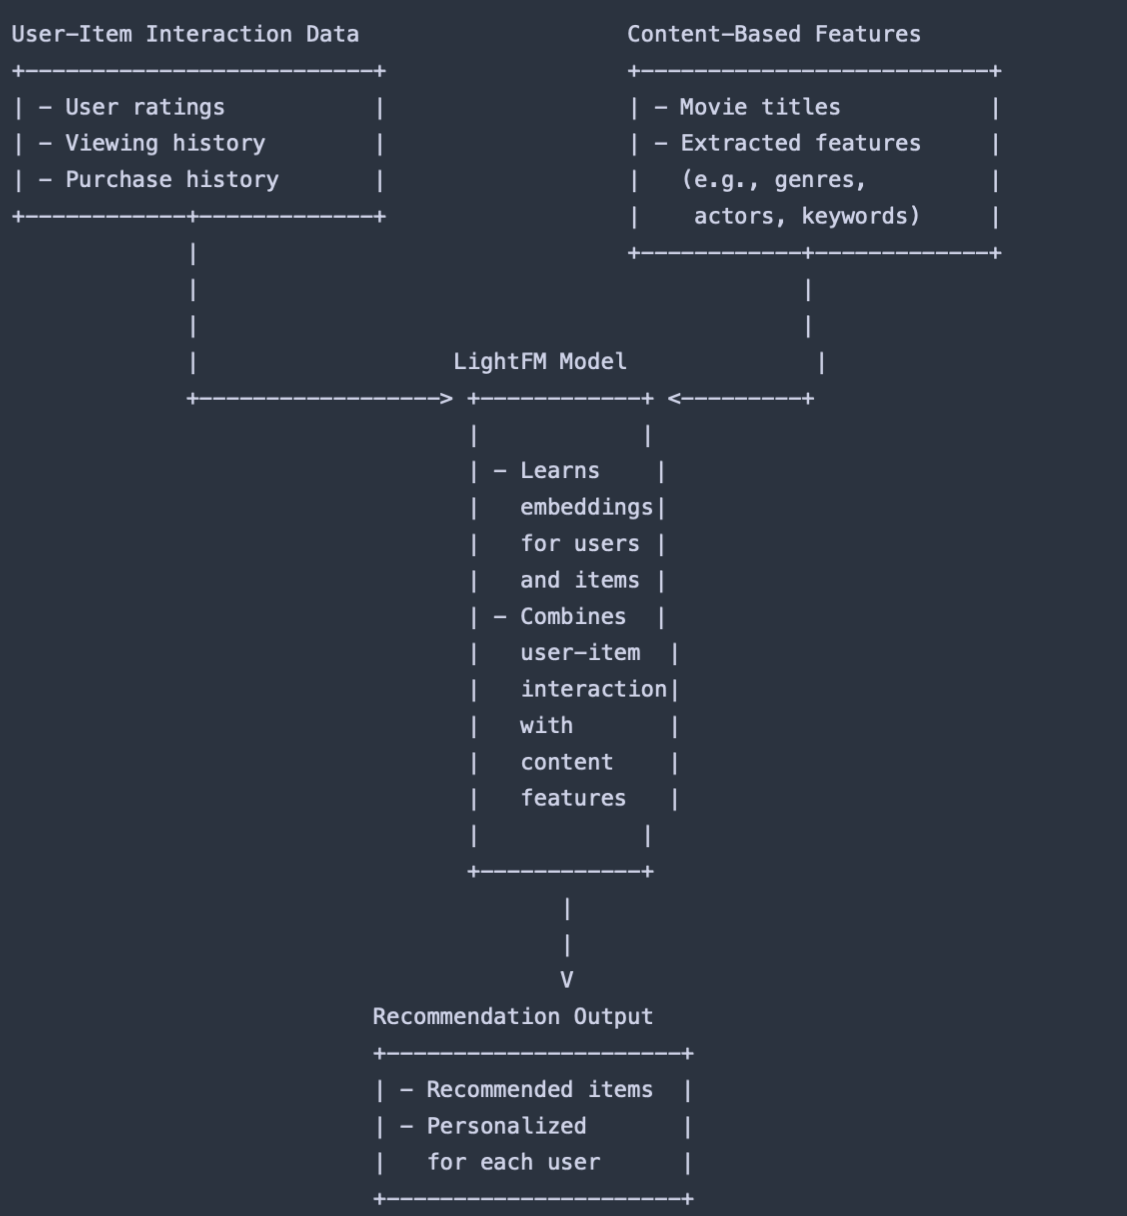



LightFM allows you to integrate both user-item interaction data and additional item (and/or user) features.

### Generate Content-Based Features from Movie Titles

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(movies_df['title'])

# tfidf_matrix now contains the content-based features for each movie


### Prepare the Data for LightFM


In [30]:
# Get feature names
feature_names = tfidf.get_feature_names_out()

# Create a DataFrame for LightFM
item_features = pd.DataFrame(tfidf_matrix.todense(), columns=feature_names)
item_features['movie_id'] = movies_df['movie_id']
# Exclude 'movie_id' from the features list
item_features_list = []
for i, row in item_features.iterrows():
    features = row.index[row > 0].tolist()
    features = [f for f in features if f != 'movie_id']  # Exclude 'movie_id'
    item_features_list.append((row['movie_id'], features))



In [26]:
### Making Predictions